In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms as transforms
# datasets
import torchvision
from torch.utils.data import DataLoader
from tqdm import tqdm

import torch.nn.functional as F

In [2]:
BATCH_SIZE = 128
IMG_SIZE = 32

def load_transformed_dataset():
    data_transforms = transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: (x*2)-1)
    ])

    train  = torchvision.datasets.MNIST(root='/ssd_scratch/cvit/anirudhkaushik/datasets/', train=True, download=False, transform=data_transforms)
    test   = torchvision.datasets.MNIST(root='/ssd_scratch/cvit/anirudhkaushik/datasets/', train=False, download=False, transform=data_transforms)


    return torch.utils.data.ConcatDataset([train, test])


data = load_transformed_dataset()
data_loader = DataLoader(data, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)

In [10]:
from noise_scheduler import NoiseScheduler
beta_start = 0.0001
beta_end = 0.02
timesteps = 100

img_channels = 1

noise_scheduler = NoiseScheduler(beta_start, beta_end, timesteps, BATCH_SIZE, img_channels)
noise_scheduler.beta_scheduler()

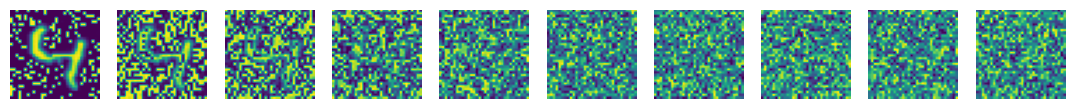

In [11]:
image = next(iter(data_loader))[0]

plt.figure(figsize=(15,15))
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(0, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int((idx/stepsize)+1))
    # remove axis of subplot
    plt.axis('off')
    image, noise  = noise_scheduler.forward_diffusion(image, t)
    noise_scheduler.show(image.cpu().detach())

In [12]:
from unet import SimpleUNET

model = SimpleUNET()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62431971


SimpleUNET(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbedding()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (bnorm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d

In [13]:
def get_loss(model, x_0, t):
    x_noisy, noise = noise_scheduler.forward_diffusion(x_0, t)
    noise_pred = model(x_noisy, t)
    return F.l1_loss(noise, noise_pred)

In [14]:
epoch_start = 0
def load_model_from_checkpoint(model, PATH):
    checkpoint = torch.load(PATH)
    model.load_state_dict(checkpoint['model_state_dict'])
    epoch = checkpoint['epoch']
    print(f"Restarting from epoch {epoch}")
    

def restart_last_checkpoint(model,PATH = f'/ssd_scratch/cvit/anirudhkaushik/checkpoints/unet_latest.pt' ):
    
    load_model_from_checkpoint(model, PATH)
    

cuda
Restarting from epoch 110


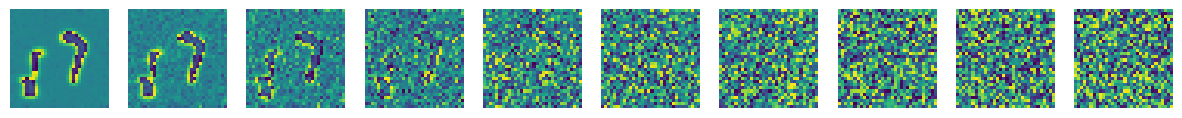

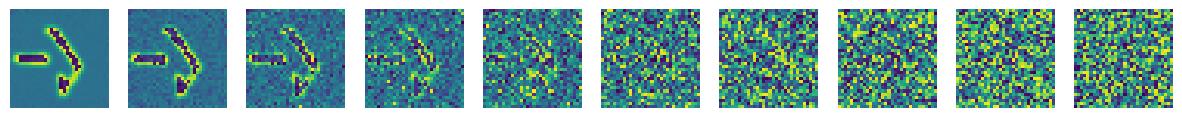

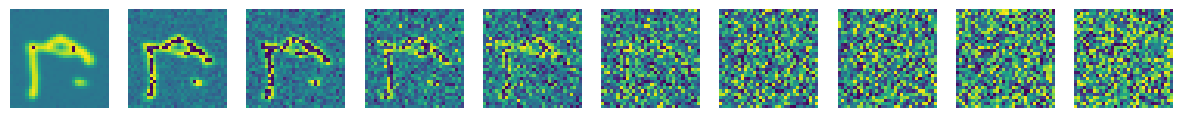

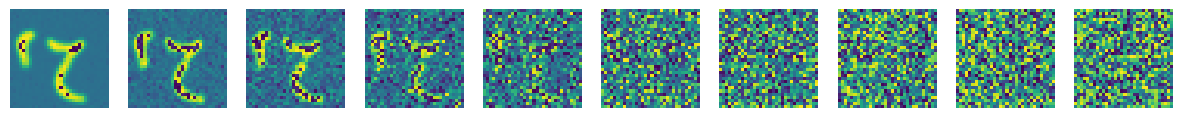

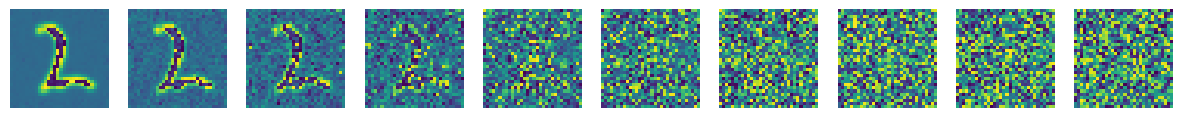

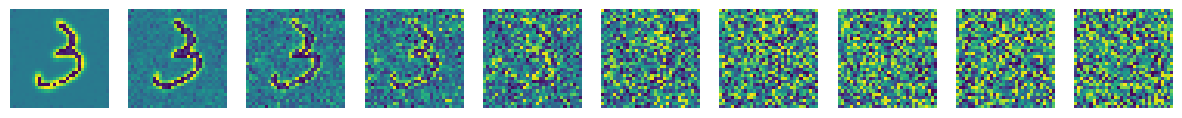

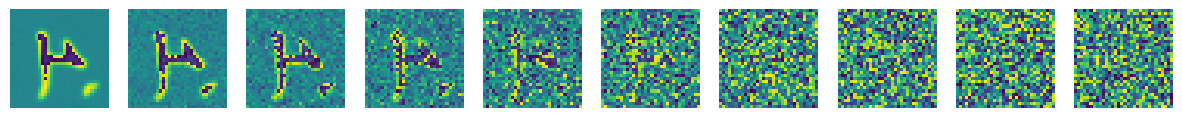

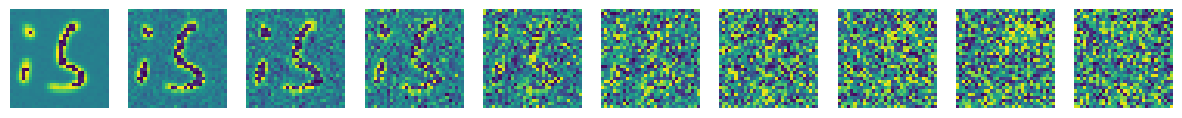

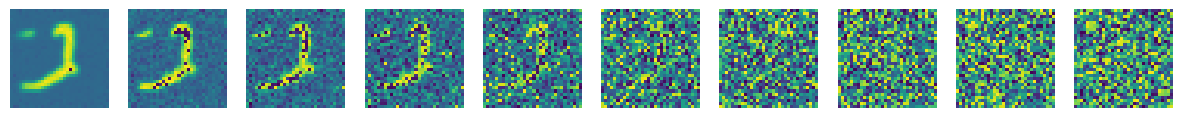

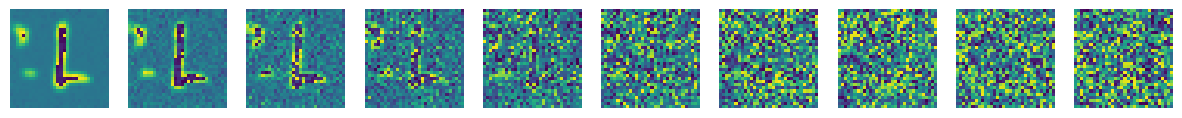

In [15]:
from unet import UNet
def test_sample_output():
    torch.cuda.empty_cache()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    # load_model_from_checkpoint(model, "/ssd_scratch/cvit/anirudhkaushik/checkpoints/unet.pt")
    model = UNet(1,1)
    # model = torch.nn.DataParallel(model)
    restart_last_checkpoint(model)

    model = model.to(device)



    t = torch.randint(0, timesteps, (BATCH_SIZE,), device=device).long()
    for i in range(10):
        noise_scheduler.sample_plot_image(IMG_SIZE, model)
test_sample_output()

In [9]:
# from torch.optim import Adam

# torch.cuda.empty_cache()
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# print(device)
# # load_model_from_checkpoint(model, "/ssd_scratch/cvit/anirudhkaushik/checkpoints/unet.pt")
# model = SimpleUNET()
# model = torch.nn.DataParallel(model)
# restart_last_checkpoint(model)
# model = model.to(device)
# optimizer = Adam(model.parameters(), lr=0.001)
# epochs = 500

# for epoch in range(epoch_start, epochs):
#     for step, batch in enumerate(data_loader):
#         optimizer.zero_grad()

#         t = torch.randint(0, timesteps, (BATCH_SIZE,), device=device).long()

#         loss = get_loss(model, batch[0], t)
#         loss.backward()
#         optimizer.step()

#         if epoch %5 == 0 and step == 0:
#             print(f"Epoch: {epoch}, step: {step:03d}, Loss: {loss.item()}")
#             noise_scheduler.sample_plot_image(IMG_SIZE, model)

#             PATH = f'/ssd_scratch/cvit/anirudhkaushik/checkpoints/unet_{epoch}_epoch.pt'
#             torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': loss,
#                         }, PATH)
            

#             PATH = f'/ssd_scratch/cvit/anirudhkaushik/checkpoints/unet_latest.pt'
#             torch.save({
#                         'epoch': epoch,
#                         'model_state_dict': model.state_dict(),
#                         'optimizer_state_dict': optimizer.state_dict(),
#                         'loss': loss,
#                         }, PATH)

### Checkpoints